In [4]:
import tensorflow as tf
import numpy as np
import Functions.dataFrameTools as dataFrameTools
import Functions.processGen as processGen

import pandas as pd

from parametricVAE import dVAE, plot_history,freeze_layers_before, unfreeze_all_layers, loadData2, my_loadData2, loadData2, custom_sigmoid_cross_entropy_loss_with_logits

In [5]:
dfn = dataFrameTools.normalizeDF(0).astype('float32')


visual_df =pd.read_csv("../data/clip_sBIKED_reduced.csv", index_col=0)
columns_to_drop = [col for col in visual_df.columns if 'color' in col]
visual_df.drop(columns=columns_to_drop, inplace=True)
boolean_columns = visual_df.select_dtypes(include=['bool']).columns
visual_df[boolean_columns] = visual_df[boolean_columns].astype(int)
visual_df = visual_df.sort_index(axis=1)
visual_df = visual_df.select_dtypes(include=['number'])
constant_columns = [col for col in visual_df.columns if visual_df[col].nunique() == 1]
visual_df = visual_df.drop(columns=constant_columns)

rated_bikes_df = pd.read_csv("processed_ratings.csv")

all_my_bikes_df = dfn.loc[rated_bikes_df['bid'].unique()]

average_ratings = rated_bikes_df.groupby('bid')['rating'].mean()
usable_bikes = visual_df.loc[average_ratings[average_ratings > 0.7].index]
unusable_bikes = visual_df.loc[average_ratings[average_ratings < 0.3].index]
meaningfull_bikes_df = pd.concat([usable_bikes, unusable_bikes])
meaningfull_bikes_df['usable'] = meaningfull_bikes_df.index.isin(usable_bikes.index).astype(int)

Loaded Imputed Dataframe in  1.3967859745025635 seconds


### Replace bikes in dval that are in all_my_bikes_df with new unseen bikes from dtrain. This ensure that validation always contains bikes that are not trained with.

In [6]:
dtrain, dval, dtest, ddims = loadData2()

ids = rated_bikes_df['bid'].unique()
used_indices = set()
replaced = []

for index in dval.index.intersection(ids):
    while True:
        random_index = dtest.sample(n=1).index[0]
        if random_index not in used_indices and random_index not in ids:
            dval.loc[index] = dtest.loc[random_index].values
            dtest = dtest.drop(index=random_index)
            used_indices.add(random_index)
            replaced.append(index)
            break

print(f'Replaced indices: {replaced}')

Loaded Imputed Dataframe in  1.6195948123931885 seconds
Replaced indices: [1964, 533, 4417, 4677, 805, 1459, 4738, 3410, 571, 1925, 1733, 3854, 266, 196, 1636, 2185, 4363, 723]


In [7]:
ddims = 2395

dataVAE=dVAE(ddims, 128, 0.1, 1e-3).build_vae_keras_model_mean()
dataVAE.load_weights('model weights/dataVAE.h5')
dataVAE_decoder = dataVAE.get_layer('decoder')
dataVAE_encoder = dataVAE.get_layer('encoder')

# tunedVAE=dVAE(ddims, 128, 0.1, 1e-3).build_vae_keras_model_mean()
# tunedVAE.load_weights('model weights/tuned2VAE.h5')
# tunedVAE_decoder = tunedVAE.get_layer('decoder')
# tunedVAE_encoder = tunedVAE.get_layer('encoder')

### Train

Epoch 1/1000
1/1 [==============================] - 4s 4s/step - loss: 516.0136 - val_loss: 520.1764
Epoch 2/1000
1/1 [==============================] - 0s 119ms/step - loss: 516.1591 - val_loss: 519.9979
Epoch 3/1000
1/1 [==============================] - 0s 112ms/step - loss: 514.8080 - val_loss: 520.1792
Epoch 4/1000
1/1 [==============================] - 0s 118ms/step - loss: 513.6684 - val_loss: 519.8943
Epoch 5/1000
1/1 [==============================] - 0s 115ms/step - loss: 512.4194 - val_loss: 520.0938
Epoch 6/1000
1/1 [==============================] - 0s 113ms/step - loss: 513.7242 - val_loss: 519.8616
Epoch 7/1000
1/1 [==============================] - 0s 113ms/step - loss: 510.7199 - val_loss: 519.8740
Epoch 8/1000
1/1 [==============================] - 0s 120ms/step - loss: 509.7450 - val_loss: 520.1411
Epoch 9/1000
1/1 [==============================] - 0s 112ms/step - loss: 511.3506 - val_loss: 519.7984
Epoch 10/1000
1/1 [==============================] - 0s 115ms/step 

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

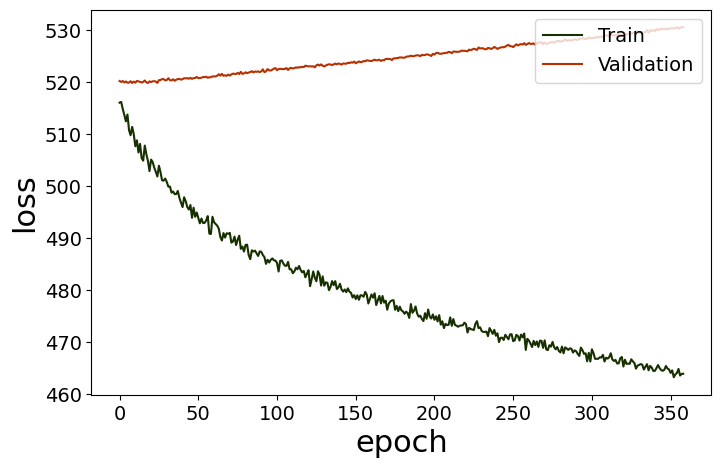

In [47]:
ddims = 2395
all_my_bikes_df_train = dfn.loc[all_my_bikes_df.index.unique()]


tunedVAE = dVAE(ddims, 128, 0.01, 1e-4).build_vae_keras_model()
tunedVAE.load_weights('model weights/dataVAE.h5')

freeze_layers_before(tunedVAE.get_layer('decoder'), 'd3')
freeze_layers_before(tunedVAE.get_layer('encoder'), 'e3')

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=350)
history = tunedVAE.fit(x=all_my_bikes_df_train, y=all_my_bikes_df_train, epochs=1000, batch_size=len(all_my_bikes_df.index), validation_data=(dval, dval), callbacks=[callback])

unfreeze_all_layers(tunedVAE)

tunedVAE.save_weights('model weights/tuned2_redoVAE.h5')
tunedVAE = dVAE(ddims, 128, 0.01, 1e-4).build_vae_keras_model_mean()
tunedVAE.load_weights('model weights/tuned2_redoVAE.h5')
encoder_tuned = tunedVAE.get_layer('encoder')
plot_history(history)


Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 522.1976 - val_loss: 524.6189
Epoch 2/200
1/1 [==============================] - 0s 103ms/step - loss: 521.2646 - val_loss: 524.2543
Epoch 3/200
1/1 [==============================] - 0s 105ms/step - loss: 520.3112 - val_loss: 524.2965
Epoch 4/200
1/1 [==============================] - 0s 103ms/step - loss: 517.1047 - val_loss: 523.9972
Epoch 5/200
1/1 [==============================] - 0s 104ms/step - loss: 516.7668 - val_loss: 524.2294
Epoch 6/200
1/1 [==============================] - 0s 103ms/step - loss: 518.5414 - val_loss: 524.0441
Epoch 7/200
1/1 [==============================] - 0s 102ms/step - loss: 515.7244 - val_loss: 524.2405
Epoch 8/200
1/1 [==============================] - 0s 104ms/step - loss: 513.8372 - val_loss: 524.2734
Epoch 9/200
1/1 [==============================] - 0s 107ms/step - loss: 516.7618 - val_loss: 524.1933
Epoch 10/200
1/1 [==============================] - 0s 103ms/step - loss: 51

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

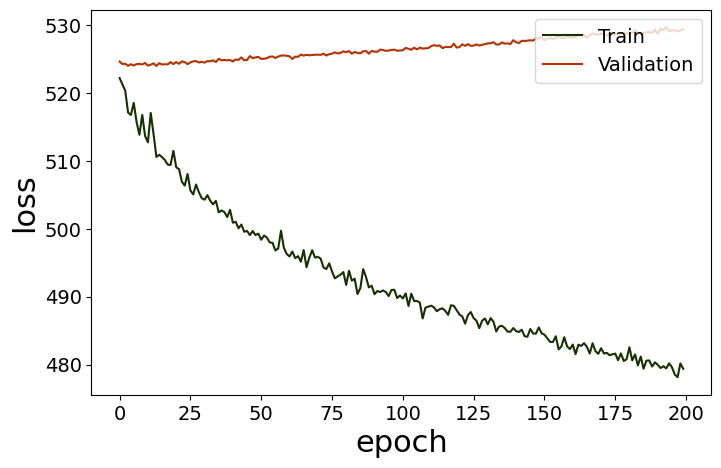

In [38]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

all_my_bikes_df_train = dfn.loc[all_my_bikes_df.index.unique()]

ddims = 2395


# tunedVAE = dVAE(ddims, 128, 0.05, 1e-4).build_vae_keras_model()
# tunedVAE.load_weights('model weights/dataVAE.h5')
# freeze_layers_before(tunedVAE.get_layer('decoder'), 'd3')
# freeze_layers_before(tunedVAE.get_layer('encoder'), 'e3')

# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
# history = tunedVAE.fit(x=all_my_bikes_df_train, y=all_my_bikes_df_train, epochs=1000, batch_size=len(all_my_bikes_df.index), validation_data=(dval, dval), callbacks=[callback])
# plot_history(history)

# unfreeze_all_layers(tunedVAE)

# tunedVAE.save_weights('model weights/temp.h5')
tunedVAE = dVAE(ddims, 128, 0.1, 1e-4).build_vae_keras_model()
tunedVAE.load_weights('model weights/dataVAE.h5')
# tunedVAE.load_weights('model weights/temp.h5')
freeze_layers_before(tunedVAE.get_layer('decoder'), 'd4')
freeze_layers_before(tunedVAE.get_layer('encoder'), 'e4')
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=300)
history = tunedVAE.fit(x=all_my_bikes_df_train, y=all_my_bikes_df_train, epochs=200, batch_size=len(all_my_bikes_df.index), validation_data=(dval, dval), callbacks=[callback])
plot_history(history)
unfreeze_all_layers(tunedVAE)

# Save the final weights
tunedVAE.save_weights('model weights/tuned_gradual_unfreeze_and_lr_scheduler.h5')

# # Load the tuned model for further evaluation
# tunedVAE = dVAE(ddims, 128, 0.01, 1e-4).build_vae_keras_model_mean()
# tunedVAE.load_weights('model weights/tuned_gradual_unfreeze_and_lr_scheduler.h5')
# encoder_tuned = tunedVAE.get_layer('encoder')

# 1/1 [==============================] - 0s 92ms/step - loss: 478.7755 - val_loss: 530.1953

In [45]:
from scipy.spatial.distance import cdist



encoder =  dataVAE.get_layer('encoder')
decoder = dataVAE.get_layer('decoder')
latent_data = encoder.predict(all_my_bikes_df)  
res = (tf.math.sigmoid(decoder.predict(latent_data))).numpy()  
indexnames = [i for i in all_my_bikes_df.index]
data_regen_df = pd.DataFrame(data=res, index=indexnames, columns=dfn.columns)  

encoder =  tunedVAE.get_layer('encoder')
decoder = tunedVAE.get_layer('decoder')
latent_tuned = encoder.predict(all_my_bikes_df)  
res = (tf.math.sigmoid(decoder.predict(latent_tuned))).numpy()  
tuned_regen_df = pd.DataFrame(data=res, index=indexnames, columns=dfn.columns)  



average_distance_data_regen = np.mean(np.sqrt(np.sum((all_my_bikes_df - data_regen_df) ** 2, axis=1)))
average_distance_tuned_regen = np.mean(np.sqrt(np.sum((all_my_bikes_df - tuned_regen_df) ** 2, axis=1)))


print(f'Average distance to edited_df for data_regen_df: {average_distance_data_regen}')
print(f'Average distance to edited_df for tuned_regen_df: {average_distance_tuned_regen}')
print(f'Percent decrease: {-(average_distance_tuned_regen-average_distance_data_regen)*100/average_distance_tuned_regen}')


4/4 [==============================] - 0s 3ms/step
Average distance to edited_df for data_regen_df: 3.743070363998413
Average distance to edited_df for tuned_regen_df: 2.51955246925354
Percent decrease: 48.560921420595015


In [43]:
# non_edited_df = dfn[~dfn.index.isin(all_my_bikes_df.index)]


encoder =  dataVAE.get_layer('encoder')
decoder = dataVAE.get_layer('decoder')
latent_data = encoder.predict(dval)  
res = (tf.math.sigmoid(decoder.predict(latent_data))).numpy()  
indexnames = [i for i in dval.index]
data_non_regen_df = pd.DataFrame(data=res, index=indexnames, columns=dfn.columns)  

encoder =  tunedVAE.get_layer('encoder')
decoder = tunedVAE.get_layer('decoder')
latent_tuned = encoder.predict(dval)  
res = (tf.math.sigmoid(decoder.predict(latent_tuned))).numpy()  
tuned_non_regen_df = pd.DataFrame(data=res, index=indexnames, columns=dfn.columns) 

average_distance_data_regen = np.mean(np.sqrt(np.sum((dval - data_non_regen_df) ** 2, axis=1)))
average_distance_tuned_regen = np.mean(np.sqrt(np.sum((dval - tuned_non_regen_df) ** 2, axis=1)))


print(f'Average distance to non_edited_df for data_non_regen_df: {average_distance_data_regen}')
print(f'Average distance to non_edited_df for tuned_non_regen_df: {average_distance_tuned_regen}')
print(f'Percent increase: {(average_distance_tuned_regen-average_distance_data_regen)*100/average_distance_tuned_regen}')

# Average distance to non_edited_df for tuned_non_regen_df: 4.997858037005397

22/22 [==============================] - 0s 3ms/step
Average distance to non_edited_df for data_non_regen_df: 4.382198810577393
Average distance to non_edited_df for tuned_non_regen_df: 4.557642936706543
Percent increase: 3.8494486857702443


In [46]:
non_edited_df = dfn[~dfn.index.isin(all_my_bikes_df.index)]

encoder =  dataVAE.get_layer('encoder')
decoder = dataVAE.get_layer('decoder')
latent_data = encoder.predict(non_edited_df)  
res = (tf.math.sigmoid(decoder.predict(latent_data))).numpy()  
indexnames = [i for i in non_edited_df.index]
data_non_regen_df = pd.DataFrame(data=res, index=indexnames, columns=dfn.columns)  

encoder =  tunedVAE.get_layer('encoder')
decoder = tunedVAE.get_layer('decoder')
latent_tuned = encoder.predict(non_edited_df)  
res = (tf.math.sigmoid(decoder.predict(latent_tuned))).numpy()  
tuned_non_regen_df = pd.DataFrame(data=res, index=indexnames, columns=dfn.columns) 

average_distance_data_regen = np.mean(np.sqrt(np.sum((non_edited_df - data_non_regen_df) ** 2, axis=1)))
average_distance_tuned_regen = np.mean(np.sqrt(np.sum((non_edited_df - tuned_non_regen_df) ** 2, axis=1)))

print(f'Average distance to non_edited_df for data_non_regen_df: {average_distance_data_regen}')
print(f'Average distance to non_edited_df for tuned_non_regen_df: {average_distance_tuned_regen}')
print(f'Percent increase: {(average_distance_tuned_regen-average_distance_data_regen)*100/average_distance_tuned_regen}')


138/138 [==============================] - 0s 3ms/step
Average distance to non_edited_df for data_non_regen_df: 3.532021999359131
Average distance to non_edited_df for tuned_non_regen_df: 3.873889684677124
Percent increase: 8.824920510003803


In [68]:
regen_bikes = [698 ,999,1459,1254]
regen_df = dfn.loc[regen_bikes]
encoder =  dataVAE.get_layer('encoder')
decoder = dataVAE.get_layer('decoder')
latent_data = encoder.predict(regen_df)  
res = (tf.math.sigmoid(decoder.predict(latent_data))).numpy()  
indexnames = [f"regenData{i}" for i in regen_df.index]
data_non_regen_df = pd.DataFrame(data=res, index=indexnames, columns=dfn.columns)  
data_non_regen_df.to_csv("../data/Regen.csv")  
processGen.processGen("Regen", denorm=True)

encoder =  tunedVAE.get_layer('encoder')
decoder = tunedVAE.get_layer('decoder')
latent_tuned = encoder.predict(regen_df)  
res = (tf.math.sigmoid(decoder.predict(latent_tuned))).numpy()  
indexnames = [f"regenTuned{i}" for i in regen_df.index]
tuned_non_regen_df = pd.DataFrame(data=res, index=indexnames, columns=dfn.columns) 
tuned_non_regen_df.to_csv("../data/Regen.csv")  
processGen.processGen("Regen", denorm=True)

1/1 [==============================] - 0s 18ms/step
Loaded Imputed Dataframe in  1.445857286453247 seconds
1.0 fraction valid


c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

One-hot encoding 106 features
Onehot Completed in 0.42115259170532227 seconds
Loaded Imputed Dataframe in  1.528923511505127 seconds


c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

1/1 [==============================] - 0s 23ms/step
Loaded Imputed Dataframe in  1.5121467113494873 seconds
1.0 fraction valid


c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

One-hot encoding 106 features
Onehot Completed in 0.45909547805786133 seconds
Loaded Imputed Dataframe in  1.6417553424835205 seconds


c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

,SSSIDECX3,SSSIDECX2,SSSIDECX1,SSSIDECY2,SSSIDECY1,STEMBENDS,FRONTROTORBOLTS,Shoe up angle,Down tube front diameter,LRTHICK,...,Saddle type OHCLASS: fi'zi:k Arione,Saddle type OHCLASS: fi'zi:k Arione TRI,Saddle type OHCLASS: fi'zi:k Gobi,Saddle type OHCLASS: fi'zi:k Tundra,TRACK_ERGO OHCLASS: 1,FRONTPANNIER style OHCLASS: 1,Top tube type OHCLASS: 1,BRAZEonFDTYPE OHCLASS: FD9070F,CSAUX3_MM_RATIO OHCLASS: 1,bottle SEATTUBE0 show OHCLASS: True
regenTuned698,60.769972,129.697832,298.457744,-10.109863,17.773018,0,6,36,41.318779,10,...,0,0,0,0,0,0,0,0,0,0
regenTuned999,84.080602,195.074326,420.844713,58.226697,5.502896,0,6,36,38.542768,10,...,0,0,0,0,0,0,0,0,0,0
regenTuned1459,85.937260,137.171848,310.656111,-5.438448,13.019944,0,6,37,42.174275,10,...,0,0,0,0,0,0,0,0,0,0
regenTuned1254,116.334367,174.161898,278.084636,-11.567746,9.436584,0,6,37,37.399323,10,...,0,0,0,0,0,0,0,0,0,0


In [22]:
from pathlib import Path
import shutil

def copy_images_from_df(exclusion_df, save_path):
    for _, row in exclusion_df.iterrows():
        # style = row['Style']
        bike_id = row.name
        
        copy_from = Path(f"../Standardized Images/{bike_id}.png")
        copy_to = Path(f"{save_path}/{bike_id}.png")
        
        copy_to.parent.mkdir(parents=True, exist_ok=True)
        if copy_from.exists():
            shutil.copy(copy_from, copy_to)
        else:
            print(f"Image not found: {copy_from}")

copy_images_from_df(dval, 'images/dval/')

In [23]:
regen_bikes = [176 ,721,916,694]
regen_df = dfn.loc[regen_bikes]
encoder =  dataVAE.get_layer('encoder')
decoder = dataVAE.get_layer('decoder')
latent_data = encoder.predict(regen_df)  
res = (tf.math.sigmoid(decoder.predict(latent_data))).numpy()  
indexnames = [f"regenData{i}" for i in regen_df.index]
data_non_regen_df = pd.DataFrame(data=res, index=indexnames, columns=dfn.columns)  
data_non_regen_df.to_csv("../data/Regen.csv")  
processGen.processGen("Regen", denorm=True)

encoder =  tunedVAE.get_layer('encoder')
decoder = tunedVAE.get_layer('decoder')
latent_tuned = encoder.predict(regen_df)  
res = (tf.math.sigmoid(decoder.predict(latent_tuned))).numpy()  
indexnames = [f"regenTuned{i}" for i in regen_df.index]
tuned_non_regen_df = pd.DataFrame(data=res, index=indexnames, columns=dfn.columns) 
tuned_non_regen_df.to_csv("../data/Regen.csv")  
processGen.processGen("Regen", denorm=True)

1/1 [==============================] - 0s 22ms/step
Loaded Imputed Dataframe in  1.337205171585083 seconds
1.0 fraction valid


c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

One-hot encoding 106 features
Onehot Completed in 0.6757831573486328 seconds
Loaded Imputed Dataframe in  1.5293700695037842 seconds


c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

1/1 [==============================] - 0s 24ms/step
Loaded Imputed Dataframe in  1.4583871364593506 seconds
1.0 fraction valid


c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

One-hot encoding 106 features
Onehot Completed in 0.3970470428466797 seconds
Loaded Imputed Dataframe in  1.5198352336883545 seconds


c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\Thesis1\My_ratings\BIKE_RATINGS\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

,SSSIDECX3,SSSIDECX2,SSSIDECX1,SSSIDECY2,SSSIDECY1,STEMBENDS,FRONTROTORBOLTS,Shoe up angle,Down tube front diameter,LRTHICK,...,Saddle type OHCLASS: fi'zi:k Arione,Saddle type OHCLASS: fi'zi:k Arione TRI,Saddle type OHCLASS: fi'zi:k Gobi,Saddle type OHCLASS: fi'zi:k Tundra,FRONTPANNIER style OHCLASS: 1,Top tube type OHCLASS: 1,BRAZEonFDTYPE OHCLASS: FD9070F,CSAUX3_MM_RATIO OHCLASS: 1,bottle SEATTUBE0 show OHCLASS: True,bottle DOWNTUBE0 show OHCLASS: True
regenTuned176,88.566668,169.849050,290.869615,-7.192263,36.140712,0,6,35,44.226606,10,...,0,0,0,0,0,0,0,0,0,0
regenTuned721,62.753018,126.601499,283.519570,-3.241056,-3.521240,0,6,36,39.045276,10,...,0,0,0,0,0,0,0,0,0,0
regenTuned916,84.856805,150.695973,330.463320,-0.656035,-16.189500,0,6,35,46.577652,10,...,0,0,0,0,0,0,0,0,0,0
regenTuned694,53.408238,145.724661,319.165893,-5.621363,6.614248,0,6,37,40.360333,10,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# average_ratings = rated_bikes_df.groupby('bid')['rating'].mean()
# usable_bikes = visual_df.loc[average_ratings[average_ratings > 0.7].index]
# unusable_bikes = visual_df.loc[average_ratings[average_ratings < 0.3].index]
# meaningfull_bikes_df = pd.concat([usable_bikes, unusable_bikes])
# meaningfull_bikes_df['usable'] = meaningfull_bikes_df.index.isin(usable_bikes.index).astype(int)

In [26]:
# def history_info(history):
#     train_accuracy = history.history['loss']
#     val_accuracy = history.history['val_loss']
#     # Ensure the accuracy lists are not empty
#     if train_accuracy and val_accuracy:
#         # Calculate the final and initial values
#         final_train_accuracy = train_accuracy[-1]
#         initial_train_accuracy = train_accuracy[0]
        
#         final_val_accuracy = val_accuracy[-1]
#         initial_val_accuracy = val_accuracy[0]
        
#         # Calculate percentage changes
#         if initial_train_accuracy > 0:
#             train_accuracy_decrease = ((initial_train_accuracy - final_train_accuracy) / initial_train_accuracy) * 100
#         else:
#             train_accuracy_decrease = np.nan  # Handle division by zero if initial accuracy is zero

#         if initial_val_accuracy > 0:
#             val_accuracy_increase = ((final_val_accuracy - initial_val_accuracy) / initial_val_accuracy) * 100
#         else:
#             val_accuracy_increase = np.nan  # Handle division by zero if initial accuracy is zero
        
#         # Print the results
#         print(f"Percent decrease in training accuracy: {train_accuracy_decrease:.2f}%")
#         print(f"Percent increase in validation accuracy: {val_accuracy_increase:.2f}%")
#     else:
#         print("Accuracy data is not available in the history object.")

In [19]:
# # dtrain,dval,dtest,ddims=my_loadData2(meaningfull_bikes_df)
# ddims = 2395
# # meaningfull_bikes_df.pop(['usable'])
# meaningfull_bikes_df_train = df.loc[meaningfull_bikes_df.index.unique()]


# tunedVAE = dVAE(ddims, 128, 0.01, 1e-4).build_vae_keras_model()
# tunedVAE.load_weights('model weights/dataVAE.h5')

# freeze_layers_before(tunedVAE.get_layer('decoder'), 'd4')
# freeze_layers_before(tunedVAE.get_layer('encoder'), 'e4')

# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=350)
# history = tunedVAE.fit(x=meaningfull_bikes_df_train, y=meaningfull_bikes_df_train, epochs=1000, batch_size=len(meaningfull_bikes_df.index), validation_data=(dval, dval), callbacks=[callback])

# unfreeze_all_layers(tunedVAE)

# tunedVAE.save_weights('model weights/tuned_usefull_bikes_VAE.h5')
# tunedVAE = dVAE(ddims, 128, 0.01, 1e-4).build_vae_keras_model_mean()
# tunedVAE.load_weights('model weights/tuned_usefull_bikes_VAE.h5')
# encoder_tuned = tunedVAE.get_layer('encoder')

# history_info(history)
# plot_history(history)

In [27]:
# history_info(history)


Percent decrease in training accuracy: 12.74%
Percent increase in validation accuracy: 3.12%
